### Write a class with the following functions: 
- gp_model()
- set_initial_state()
- stim_state = sample()
- state_est = predict_state()
- transition_stete()


In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
# plt.style.use('dark_background')
import GPy

In [2]:
path = "Mark_4sec_CA3PSD_ISO_freqamp_020619.csv"

In [3]:
class state_dr_gp:
    '''
    A class to run a Gaussian Process model. 
    
    
    '''
    def gp_model(self, csv_path):
        # Import datasets as pandas
        CA1_df = pd.read_csv(path)

        # Get frequency and amplitudes
        U1 = CA1_df.iloc[:,  0:2]
        # Get the coordinate of pre stimulation gamma 
        X0_coords = np.arange(33,52)

        # sum of pre stimulation gamma
        data = np.sum(CA1_df.iloc[:, X0_coords], axis=1)
        X0_psd = pd.DataFrame(data=data, columns=['sum_preStim_gamma'])
        X0_psd = X0_psd*1e10 # Need values >0 for GP model
        N_trials = np.size(X0_psd, axis=0)
        lower_bound = np.min(U1, axis=0)
        upper_bound = np.max(U1, axis=0)

        X1_coords = np.arange(133,152)
        X1 = np.sum(CA1_df.iloc[:, X1_coords],axis=1)
        X1 = np.array(X1)
        X1 =X1[:, np.newaxis] # reshape
        X1 = X1*1e10 # bring to >0 range        
       
        return X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials;
    
    # initialize_data_dr_sim() function
    def initialize_data_dr_sim(self, U1, X0_psd, X1, kernel, slice_dim, ylabel):
       
        # input_data
        # U1_X0 = U1.join(X0_psd)
        
        # create simple GP model
        m = GPy.models.GPRegression(U1,X1,kernel)
        figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(1),legend=False, xlabel='Stim. Freq.', ylabel='Stim. Amp.',
                      title="before Optimization");
        display(canvas);
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax);
        
        # optimize and plot
        m.optimize(messages=True,max_f_eval = 1000);
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
        display(canvas)
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax)
        
        # Plotting slices of the model at amplitudes of 0, 10, and 50
        slices = [0, 10, 50]
        figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

        for i, y in zip(range(3), slices):
            print((1,y));

            canvas = m.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                            xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

        display(canvas);
        
        # Min and Max of State
        
        # Number of trials
        
        
        return U1_X0, X1, m; 
    
    
    #Sample Function
    def sample(self,testX, m):

        posteriorTestY = np.empty((100))
        simY  = np.empty((100))
        simMse = np.empty((100))

        state_est = m.posterior_samples_f(testX, full_cov=True, size=1)[:,0,0]
        simY, simMse = m.predict(testX)

        # print("mean is: \n",simY[0],"\n\n Variance is: \n", simMse[0])
        # # posteriorTestY
        # print(np.shape(posteriorTestY),'\n',posteriorTestY[0:10])
        # print(np.shape(simY),'\n', np.shape(simMse))

        return state_est, simY, simMse;
    
    def transition_state(self, U1, X0_psd, state_est, testX):
        state_data_dr = X0_psd
        current_state = np.append(X0_psd, state_est[:,0:1], axis=0)
#         testX_shape_row, testX_shape_col = np.shape(testX)
        
#         current_state = np.empty(())
        
        return current_state
        
    

In [4]:
model = state_dr_gp()

In [5]:
X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials = model.gp_model(path)

In [6]:
print(X0_psd, '\n',U1[0:4])

     sum_preStim_gamma
0             3.266571
1             2.425945
2             3.117866
3             2.868627
4             3.521665
..                 ...
379           1.268502
380           1.239859
381           1.880050
382           1.199899
383           1.343332

[384 rows x 1 columns] 
    Stim_1  Stim_2
0      17      30
1      42      40
2      35      30
3      23      50


In [7]:
print(np.shape(U1), np.shape(X0_psd))

(384, 2) (384, 1)


In [8]:
# input_data
U1_X0 = U1.join(X0_psd)

In [9]:
hill_sum_preStim_gamma = np.empty((100))
min_sum_preStim_gamma = np.min(U1_X0['sum_preStim_gamma'])
max_sum_preStim_gamma = np.max(U1_X0['sum_preStim_gamma'])
step_size = (max_sum_preStim_gamma-min_sum_preStim_gamma)/50
hill_sum_preStim_gamma[0:50] = np.arange(min_sum_preStim_gamma, max_sum_preStim_gamma, step_size)
hill_sum_preStim_gamma[50:100] = np.arange(max_sum_preStim_gamma,min_sum_preStim_gamma, -step_size)
print(hill_sum_preStim_gamma[0:3])

[0.81379952 1.01750611 1.22121269]


### Normal Basian Optimization: training a model and sampling

In [10]:
sampling_freq = np.empty((100))
sampling_freq[:] = 35
sampling_amp = np.empty((100))
sampling_amp[:] = 40
print(np.shape(sampling_freq), np.shape(sampling_amp))

(100,) (100,)


In [11]:
testX_BaO = np.array([sampling_freq, sampling_amp])
print(np.shape(testX_BaO))
testX = np.transpose(testX_BaO)
print(testX_BaO[0:2, 0:1])
slice_dim = 1
ylabel='Predicted Gamma'

(2, 100)
[[35.]
 [40.]]


In [12]:
ker_BaO = GPy.kern.Matern52(input_dim=2, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x18cd2d27df0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x18cd2d27c70>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s19  0002   2.968181e+03   2.492593e+05 
    01s23  0012   1.133558e+03   4.767856e+00 
    02s24  0024   1.115643e+03   8.966282e-02 
    03s12  0034   1.115247e+03   6.434336e-10 
Runtime:     03s12
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x18cd2f6cd90>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x18cd2f58880>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x18cd3742af0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x18cd376b370>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x18cd376b3a0>]}

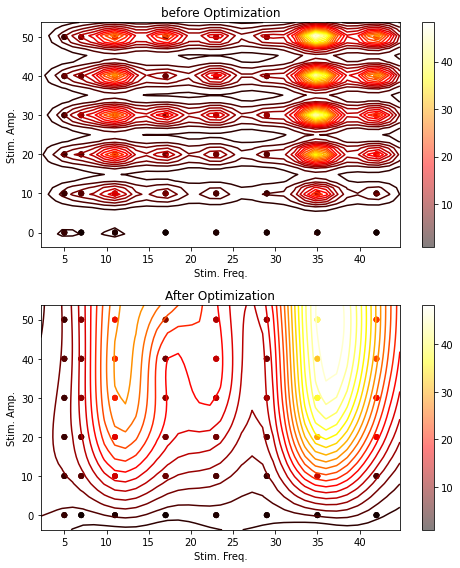

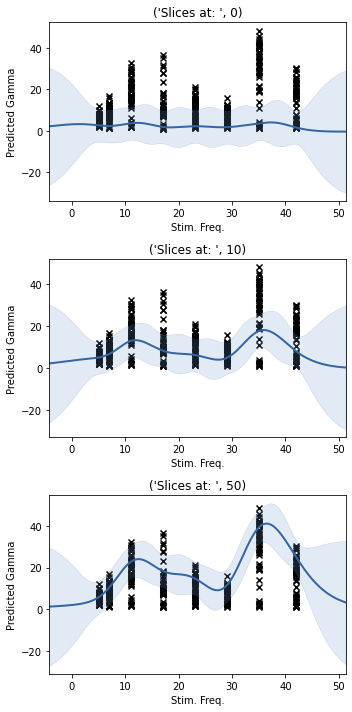

In [13]:
x_BaO, y_BaO, trained_model_BaO = model.initialize_data_dr_sim(U1, X0_psd, X1, ker_BaO, slice_dim, ylabel)

#### Sampling

In [14]:
state_est_BaO = np.empty((100, 30))
simY_BaO = np.empty((100, 30))
simMse_BaO = np.empty((100, 30))

for j in range(30):
    
    for i in range(99):
        # print(i)
        state_est_BaO[i:i+2, j], simY_BaO[i:i+2, j:j+1], simMse_BaO[i:i+2, j:j+1] = model.sample(testX_BaO, trained_model_BaO);

print("mean is: \n",simY_BaO[0, 0],"\n\n Variance is: \n", simMse_BaO[0, 0])
# posteriorTestY
print(np.shape(state_est_BaO),'\n',state_est_BaO[0:10, 0])
print(np.shape(simY_BaO),'\n', np.shape(simMse_BaO))

mean is: 
 37.21769353528691 

 Variance is: 
 15.740497567908696
(100, 30) 
 [41.66173734 35.9897257  38.42752641 34.93627807 38.56001019 30.16501893
 35.51389319 37.91778189 38.03959092 35.13343322]
(100, 30) 
 (100, 30)


In [15]:
print(testX_BaO[:,0:3])
print(np.shape(X0_psd))
print(np.shape(state_est_BaO[:,0:1]))

[[35. 35. 35.]
 [40. 40. 40.]]
(384, 1)
(100, 1)


In [16]:
current_state = np.append(X0_psd, state_est_BaO[:,0:1], axis=0)
print(np.shape(current_state), '\n', current_state[0:3, :])

(484, 1) 
 [[3.26657078]
 [2.42594512]
 [3.11786587]]


In [17]:
hill_state_est_BaO = np.empty((100, 30))
min_state_est_BaO = np.min(state_est_BaO,axis=0)
print(min_state_est_BaO[0])
max_state_est_BaO = np.max(state_est_BaO, axis=0)
print(max_state_est_BaO[0])
# step_size = np.round((max_posteriorTestY_BaO-min_posteriorTestY_BaO)/50,decimals=3)
print(step_size)
for i in range(30):
    hill_state_est_BaO[0:50,i] = np.linspace(min_state_est_BaO[i], max_state_est_BaO[i], 50)
    hill_state_est_BaO[50:100,i] = np.linspace(max_state_est_BaO[i],min_state_est_BaO[i], 50)
print(hill_state_est_BaO[0:50,1])

27.752392120197356
42.40704465219337
0.20370658621298587
[30.33490514 30.6216883  30.90847146 31.19525461 31.48203777 31.76882093
 32.05560409 32.34238725 32.6291704  32.91595356 33.20273672 33.48951988
 33.77630303 34.06308619 34.34986935 34.63665251 34.92343567 35.21021882
 35.49700198 35.78378514 36.0705683  36.35735145 36.64413461 36.93091777
 37.21770093 37.50448408 37.79126724 38.0780504  38.36483356 38.65161672
 38.93839987 39.22518303 39.51196619 39.79874935 40.0855325  40.37231566
 40.65909882 40.94588198 41.23266514 41.51944829 41.80623145 42.09301461
 42.37979777 42.66658092 42.95336408 43.24014724 43.5269304  43.81371356
 44.10049671 44.38727987]


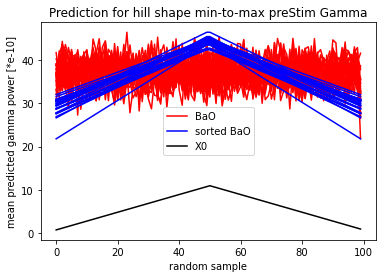

In [18]:
FIG, ax = plt.subplots()
a = plt.plot(state_est_BaO, 'r-')
b = plt.plot(hill_state_est_BaO, 'b-')
c = plt.plot(hill_sum_preStim_gamma, 'k-')
plt.ylabel('mean predicted gamma power [*e-10]')
plt.xlabel('random sample')
plt.title('Prediction for hill shape min-to-max preStim Gamma')
plt.legend([a[0],b[0],c[0]],['BaO','sorted BaO','X0']) #'Mean','+MSE', '-MSE', 
plt.show()

### State Dependent Basian Optimization: training a model and sampling

In [19]:
#GP model

# define kernel
kernel_SDBO = GPy.kern.Matern52(input_dim=3, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(3)
slice_dim_SDBO = 2
ylabel_SDBO = 'Stim. Amp.'

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x18cd586e220>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x18cd584bcd0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s17  0013   1.135959e+03   8.794069e+00 
    03s22  0034   1.111442e+03   3.171993e-09 
Runtime:     03s22
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x18cd5b052e0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x18cd5ae1100>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x18cd67dee50>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x18cd67d6bb0>]}

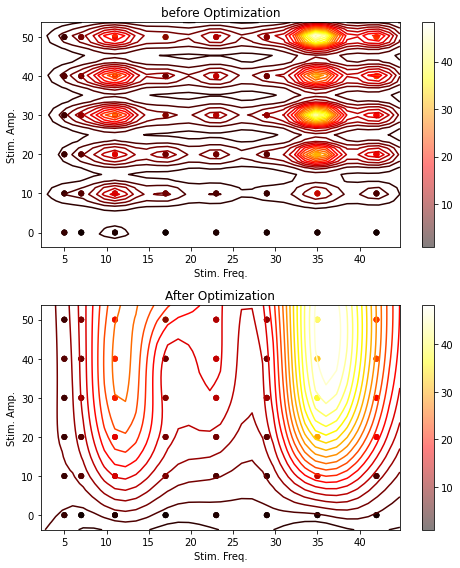

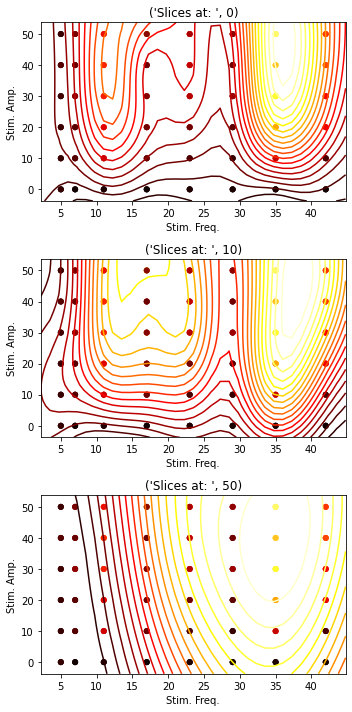

In [20]:
U1_X0, y, trained_model = model.initialize_data_dr_sim(U1_X0, X0_psd, X1, kernel_SDBO, slice_dim_SDBO, ylabel_SDBO)
# print(x)

In [28]:
testX = np.array([sampling_freq, sampling_amp, hill_sum_preStim_gamma])
print(np.shape(testX))
testX = np.transpose(testX)
# print(testX[:,0:3])

(3, 100)


In [23]:
state_est_SDBO = np.empty((100, 30))
simY_SDBO = np.empty((100, 30))
simMse_SDBO = np.empty((100, 30))

for j in range(30):
    state_est_SDBO[:, j], simY_SDBO[:, j:j+1], simMse_SDBO[:, j:j+1] = model.sample(testX, trained_model);

posteriorTestY_SDBO, simY_SDBO, simMse_SDBO = model.sample(testX, trained_model)

In [24]:
state_est_SDBO = np.empty((100, 30))
simY_SDBO = np.empty((100, 30))
simMse_SDBO = np.empty((100, 30))

for j in range(30):
    state_est_SDBO[:, j], simY_SDBO[:, j:j+1], simMse_SDBO[:, j:j+1] = model.sample(testX, trained_model);

In [25]:
print("mean is: \n",simY_SDBO[0,0],"\n\n Variance is: \n", simMse_SDBO[0, 0])
print(np.shape(state_est_SDBO),'\n',state_est_SDBO[0:10, 0])
print(np.shape(simY_SDBO),'\n', np.shape(simMse_SDBO))

mean is: 
 39.48027164844734 

 Variance is: 
 15.999478701704465
(100, 30) 
 [39.19836733 36.46395122 37.76306317 38.76872187 35.30506277 40.92966119
 36.40366763 42.66951181 37.47345169 40.1154895 ]
(100, 30) 
 (100, 30)


In [26]:
hill_state_est_SDBO = np.empty((100,30))
min_state_est_SDBO = np.min(state_est_SDBO, axis=0)
max_state_est_SDBO = np.max(state_est_SDBO, axis=0)
# step_size = (max_posteriorTestY_SDBO-min_posteriorTestY_SDBO)/50
for i in range(30):
    hill_state_est_SDBO[0:50, i] = np.linspace(min_state_est_SDBO[i], max_state_est_SDBO[i], 50)
    hill_state_est_SDBO[50:100, i] = np.linspace(max_state_est_SDBO[i],min_state_est_SDBO[i], 50)
print(hill_state_est_SDBO[0:3, 0])

[13.25983419 13.89867125 14.53750832]


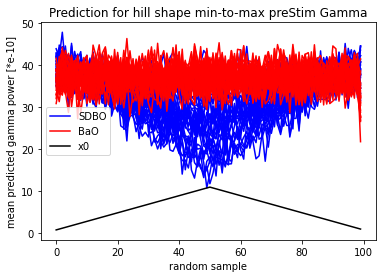

In [27]:
# plt.plot(posteriorTestY)
fig, ax = plt.subplots()
A = ax.plot(state_est_SDBO, 'b-', label='SDBO')
# plt.legend(['SDBO'])
B = ax.plot(state_est_BaO, 'r-', label='BaO')
# plt.legend(['BaO'])
# plt.plot(simY_SDBO[:, 0], 'b-')
# plt.plot(simY_SDBO[:, 0] + simMse_SDBO[:, 0]** 0.5, 'c--')
# plt.plot(simY_SDBO[:, 0] - simMse_SDBO[:, 0]** 0.5, 'c--')
C = ax.plot(hill_sum_preStim_gamma, 'k-', label='X0')
plt.ylabel('mean predicted gamma power [*e-10]')
plt.xlabel('random sample')
plt.title('Prediction for hill shape min-to-max preStim Gamma')
ax.legend([A[0], B[0], C[0]], ['SDBO', 'BaO', 'x0'])# 'Mean','+MSE', '-MSE', 
plt.show()

### Acquisition Function draft
function [X_samples, Y_samples, X_optimal_est, Y_optimal_est, Y_ground_truth] =  ...
    bayes_opt_on_state_dr_model(objective_model, input_space, n_samples, n_burn_in, acquisition_function, acq_params, measurement_function)


X_samples       = nan(n_samples, size(input_space,2));
X_optimal_est   = nan(n_samples, size(input_space,2));

Y_samples       = nan(n_samples, 1);
Y_optimal_est   = nan(n_samples, 1);
Y_ground_truth  = nan(n_samples, 1);

objective_est   = gp_object(); % GP model used in BaO 
burn_in_idx     = randi(size(input_space,1), n_burn_in,1);

objective_model.set_initial_state(); % Ground Truth simulation model 

for c1 = 1:n_samples
    
    if c1 <= n_burn_in
        X_samples(c1,:)     = input_space(burn_in_idx(c1),:);
    else
        X_samples(c1,:)     = bayes_opt_update_state_dr(objective_est, input_space, acquisition_function, acq_params, c1);
    end
    
    Y_samples(c1,1)         = objective_model.sample(X_samples(c1,:));
    
    if c1 > 1    
        objective_est.initialize_data(X_samples(1:c1,:), Y_samples(1:c1)) % Exclude NaN when initializing GP

        [X_optimal_est(c1,:), Y_optimal_est(c1,:)] ...
            = objective_est.discrete_extrema(input_space);

        Y_ground_truth(c1)  = objective_model.predict_state(X_optimal_est(c1,:));
    end
    objective_model.transition_state();
end

end


#### Next make the bayes_opt_update_state_dr()
function X_new_sample = bayes_opt_update_state_dr(objective_est, input_space, acquisition_function, acq_params, t)

[Y_mean, ~, ~, Y_uncertainty] = objective_est.predict(input_space);

switch acquisition_function
    case 'PI'
        acq_value = predicted_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'EI'
        acq_value = expected_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'UCB'
        acq_value = upper_confidence_bound(Y_mean, Y_uncertainty, acq_params, t);
end

[~, max_idx] = max(acq_value);

X_new_sample = input_space(max_idx,:);

end

##### the actual acquisition function is: upper_confidence_bound()

function ucb = upper_confidence_bound(Y_mean, Y_uncertainty, nu, t)

beta   	= 2 * log(t.^2*pi^2/(6));
ucb     = Y_mean + sqrt(nu*beta) * Y_uncertainty;

end